In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from os.path import dirname, join as pjoin
import scipy.io as sio
import h5py
import hdf5storage
import random
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from PIL import Image

In [2]:
housenumbers_train_orig = tf.keras.utils.get_file(
    origin='http://ufldl.stanford.edu/housenumbers/train.tar.gz',
    fname='train',
    untar=True
)
housenumbers_train_path = pathlib.Path(housenumbers_train_orig)
print(housenumbers_train_path)

/home/maxim/.keras/datasets/train


In [3]:
housenumbers_test_orig = tf.keras.utils.get_file(
    origin='http://ufldl.stanford.edu/housenumbers/test.tar.gz',
    fname='test',
    untar=True
)
housenumbers_test_path = pathlib.Path(housenumbers_test_orig)
print(housenumbers_test_path)

/home/maxim/.keras/datasets/test


In [4]:
housenumbers_train32_orig = tf.keras.utils.get_file(
    origin='http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
    fname='train_32x32'
)
housenumbers_train32_path = pathlib.Path(housenumbers_train32_orig)
print(housenumbers_train32_path)

/home/maxim/.keras/datasets/train_32x32


In [5]:
housenumbers_test32_orig = tf.keras.utils.get_file(
    origin='http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
    fname='test_32x32'
)
housenumbers_test32_path = pathlib.Path(housenumbers_test32_orig)
print(housenumbers_test32_path)

/home/maxim/.keras/datasets/test_32x32


In [6]:
def show_images_grid(images_array):
    fig = plt.figure(figsize = (20, 20))
    number_of_images = images_array.shape[0]
    for i in range(1, 5):
        idx = random.randint(0, number_of_images - 1)
        row_plot = fig.add_subplot(2,4,i)
        row_plot.imshow(images_array[idx])
    plt.show()
    plt.close()

In [7]:
# with h5py.File(str(housenumbers_train_path) + '/digitStruct.mat', 'r') as f:
#     print(f.keys())
#     print(f['#refs#'])
#     print(f['digitStruct']['name'][0, 0])
train32_mat = sio.loadmat('/home/maxim/.keras/datasets/train_32x32')

test32_mat = sio.loadmat('/home/maxim/.keras/datasets/test_32x32')

In [8]:
train32_x = train32_mat['X']
train32_y = train32_mat['y']

test32_x = test32_mat['X']
test32_y = test32_mat['y']

x_train, y_train = train32_x.transpose((3,0,1,2)), train32_y[:,0]

x_test, y_test = test32_x.transpose((3,0,1,2)), test32_y[:,0]

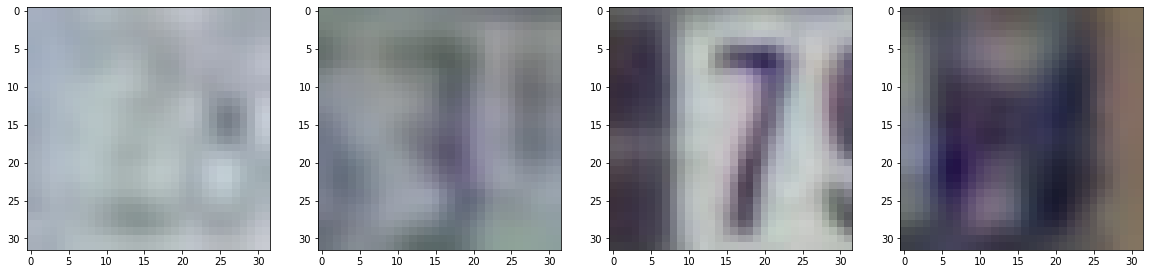

In [9]:
# show random train images
show_images_grid(x_train)

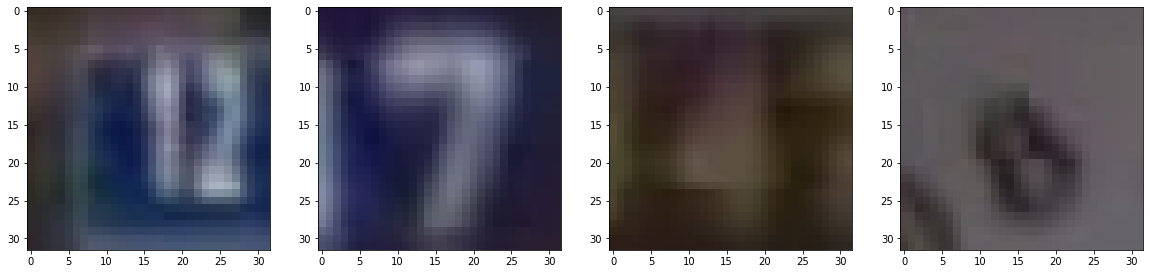

In [10]:
# show random test images
show_images_grid(x_test)

In [11]:
VALIDATION_SET_RATE = 0.05

# define image generators for train, validation and test set
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 3
EPOCHS_COUNT = 5

num_classes = 10 # (0-9)

# + 1 here is because in labels we have 10 as different class, idk why
y_train = tf.keras.utils.to_categorical(y_train, num_classes + 1)
y_test = tf.keras.utils.to_categorical(y_test, num_classes + 1)


x_validation = x_train[70001 : len(x_train)-1]
x_train = x_train[0:70000]

y_validation = y_train[70001 : len(y_train)-1]
y_train = y_train[0:70000]


print(len(x_train))
print(len(x_validation))

print(len(y_train))
print(len(y_validation))


STEPS_PER_EPOCH = np.ceil(len(x_train)/BATCH_SIZE)
STEPS_PER_EPOCH_VALIDATION = np.ceil(len(x_validation)/BATCH_SIZE)

image_generator.fit(x_train)
validation_image_generator.fit(x_validation)
test_image_generator.fit(x_test)

70000
3255
70000
3255


In [12]:
# Define 1 input 2 conv and 1 fc layer with softmax output
input_layer = layers.Input(
    shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    name='input'
)

conv_1 = layers.Conv2D(
    filters=16,
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu',
    name='conv_1'
)

conv_2 = layers.Conv2D(
    filters=40,
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu',
    name='conv_2'
)

fc_1 = layers.Dense(128, activation='relu', name='fc_1')
out = layers.Dense(11, activation='softmax', name='output')

two_conv_model = keras.Sequential([
    input_layer,
    conv_1,
    conv_2,
    layers.Flatten(),
    fc_1,
    out
])
two_conv_model.summary()

# compile the model
two_conv_model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 40)        5800      
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
fc_1 (Dense)                 (None, 128)               5243008   
_________________________________________________________________
output (Dense)               (None, 11)                1419      
Total params: 5,250,675
Trainable params: 5,250,675
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = two_conv_model.fit_generator(
   image_generator.flow(x_train, y_train),
    validation_data=validation_image_generator.flow(x_validation, y_validation),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
    epochs=EPOCHS_COUNT
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2188.0 steps, validate for 102.0 steps
Epoch 1/5
2188/2188 [==============================] - 66s 30ms/step - loss: 1.9949 - accuracy: 0.3022 - val_loss: 1.2450 - val_accuracy: 0.6080
Epoch 2/5
2188/2188 [==============================] - 70s 32ms/step - loss: 0.9387 - accuracy: 0.7121 - val_loss: 0.8423 - val_accuracy: 0.7343
Epoch 3/5
2188/2188 [==============================] - 71s 32ms/step - loss: 0.7051 - accuracy: 0.7867 - val_loss: 0.7091 - val_accuracy: 0.7856
Epoch 4/5
2188/2188 [==============================] - 71s 33ms/step - loss: 0.6012 - accuracy: 0.8195 - val_loss: 0.6186 - val_accuracy: 0.8129
Epoch 5/5
2188/2188 [==============================] - 70s 32ms/step - loss: 0.5293 - accuracy: 0.8420 - val_loss: 0.5989 - val_accuracy: 0.8160


In [14]:
# x_test[0]
test_history = two_conv_model.evaluate(test_image_generator.flow(x_test, y_test))

  ...
    to  
  ['...']
814/814 [==============================] - 8s 9ms/step - loss: 0.6761 - accuracy: 0.8063


In [15]:
def save_model_to_file(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    
def load_model_from_file():
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    return loaded_model.load_weights("model.h5")

In [16]:
two_conv_model.save('model.h5')

In [17]:
loaded_model = load_model('model.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 40)        5800      
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
fc_1 (Dense)                 (None, 128)               5243008   
_________________________________________________________________
output (Dense)               (None, 11)                1419      
Total params: 5,250,675
Trainable params: 5,250,675
Non-trainable params: 0
_________________________________________________________________


In [58]:
img = Image.fromarray(x_train[750], 'RGB')
img.save('my.png')

def load_image_into_numpy( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="float64" )
    return data

my_img = load_image_into_numpy('output_photo.jpg')
i = np.expand_dims(my_img, 0)
# i.shape
# my_img.reshape((None, 32, 32, 3))
# my_img.shape

# # define image generators for train, validation and test set
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
# x = image_generator.standardize(my_img)
# image_generator.fit(x, target_size=(32, 32, 3))
# image_generator.apply_transform(my_img)

predicted = loaded_model.predict(image_generator.flow(i))
print(predicted.argmax())
print(predicted.max())

1
0.99920756
